<a href="https://colab.research.google.com/github/GabrielM33/Classification-of-Anomalies-on-Chest-X-Ray-Dataset/blob/main/Classification_of_Anomalies_on_Chest_X_Ray_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

import sklearn.metrics
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import io
import glob
import scipy.misc
import numpy as np
import pandas as pd
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import shutil
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib
from tensorflow.keras.optimizers import RMSprop
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg

In [ ]:
LEARNING_RATE = 0.0001
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256
repo_url = 'https://github.com/adleberg/medical-ai'

In [ ]:
def load_image_into_numpy_array(image):
    image = image.convert('RGB')
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

In [ ]:
%cd -q /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
!git clone {repo_url} --quiet
%cd -q {repo_dir_path}
!git pull -q

In [ ]:
finding = 'Cardiomegaly'

In [ ]:
df = pd.read_csv("/content/medical-ai/labels.csv")
df.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP


In [ ]:
positives = df.loc[df["label"] == finding]
negatives = df.loc[df["label"] == "No Finding"]
n = len(positives)
print(n)

146


In [ ]:
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2
TRAIN_N = int(n*TRAIN_RATIO)
TEST_N = int(n*TEST_RATIO)
print(TRAIN_N, TEST_N)

116 29


In [ ]:
train_labels = pd.concat([positives[:TRAIN_N], negatives[:TRAIN_N]])
test_labels = pd.concat([positives[TRAIN_N:], negatives[TRAIN_N:n]])

Preparing Data

In [ ]:
rootdir = "/content/medical-ai/images/"
os.makedirs(rootdir+finding+"/test/positive",  exist_ok=True)
os.makedirs(rootdir+finding+"/test/negative",  exist_ok=True)
os.makedirs(rootdir+finding+"/train/positive", exist_ok=True)
os.makedirs(rootdir+finding+"/train/negative", exist_ok=True)

In [ ]:
for idx, image in positives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in positives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/negative/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/negative/"+image["filename"]
  shutil.copy(source, dst)

print("Done moving "+str(n*2)+" images to positive and negative folders.")

Done moving 292 images to positive and negative folders.


In [ ]:
positive_imgs, negative_imgs = [], []
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256

for idx, row in positives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  positive_imgs.append(load_image_into_numpy_array(image))

for idx, row in negatives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  negative_imgs.append(load_image_into_numpy_array(image))

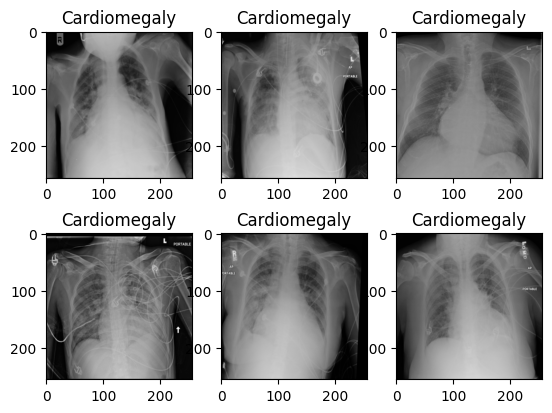

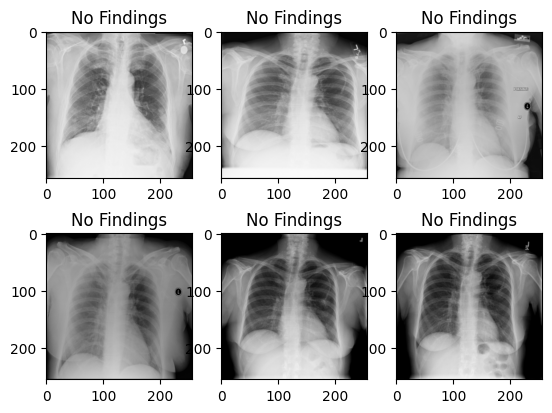

In [ ]:
for idx, img in enumerate(positive_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title(finding)
  plt.imshow(positive_imgs[idx])
plt.show()

for idx, img in enumerate(negative_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title("No Findings")
  plt.imshow(negative_imgs[idx])
plt.show()

Training Model with TensorFlow

In [ ]:
pre_trained_model = InceptionV3(
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), weights='imagenet', include_top=False)

for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Flatten()(last_output) # Flatten the output layer to 1 dimension
x = layers.Dense(1024, activation='relu')(x) # Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dropout(0.2)(x) # Add a dropout rate of 0.2
x = layers.Dense(1, activation='sigmoid')(x) # Add a final sigmoid layer for classification

model = Model(pre_trained_model.input, x) # Configure and compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print("Done compiling the model!")

87910968/87910968 [==============================] - 1s 0us/step
Done compiling the model!


In [ ]:
# Define our example directories and files
base_dir = rootdir = "/content/medical-ai/images/"
train_dir = os.path.join(base_dir, finding, 'train')
test_dir = os.path.join(base_dir, finding, 'test')

train_pos_dir = os.path.join(train_dir, 'positive')
train_neg_dir = os.path.join(train_dir, 'negative')
test_pos_dir = os.path.join(test_dir, 'positive')
test_neg_dir = os.path.join(test_dir, 'negative')

In [ ]:
train_datagen = ImageDataGenerator(
  rescale = 1./255,
  rotation_range = 40,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range = 0.2,
  zoom_range = 0.2,
  horizontal_flip = False)

val_datagen = ImageDataGenerator(rescale = 1./255)

FIX THE CELL BELOW

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode='binary')

test_generator = val_datagen.flow_from_directory(
        test_dir,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode='binary')

train_steps = len(os.listdir(train_pos_dir)) * 2
test_steps = len(os.listdir(test_pos_dir)) * 2
print("Done funneling data!")

Found 232 images belonging to 2 classes.
Found 232 images belonging to 2 classes.
Done funneling data!


Run Model

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 20,
    validation_data = test_generator,
    validation_steps = test_steps,
    verbose = 2
)

Epoch 1/20


In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.subplot(2,1,1)
plt.plot(epochs, acc, label = "train")
plt.plot(epochs, val_acc, label = "test")
plt.ylabel("Accuracy")
plt.title('Training and test accuracy')
plt.legend(loc = "lower right")

plt.subplot(2,1,2)
plt.plot(epochs, acc, label = "train")
plt.plot(epochs, val_acc, label = "test")
plt.ylabel("Loss")
plt.title('Training and test loss')
plt.legend(loc = "lower right")

Evaluating Performance

In [ ]:
def predict_image(filename):
 image = Image.open(filename).resize(IMAGE_HEIGHT, IMAGE_WIDTH)
 image_np = load_image_numpy_array(image)
 exp = np.true_divide(image_np, 255.0)
 exp = np.stack((exp,)*3, axis =-1)
 expanded = np.expand_dims(exp, axis = 0)
 return model.predict(expanded)[0][0]

def show_df_row(row):
 image_path = row['filepath']
 image = Image.open(filename).resize(IMAGE_HEIGHT, IMAGE_WIDTH)
 image_np = load_image_numpy_array(image)
 exp = np.true_divide(image_np, 255.0)
 exp = np.stack((exp,)*3, axis =-1)
 expanded = np.expand_dims(exp, axis = 0)
 pred = model.predict(expanded)[0][0]
 guess = "neg"
 if pred > 0.5: guess = "pos"
 title = "Image: " + row["filename"] + " Label: " row["label"] + "Guess: " + guess " Score:" + str(pred)
 plt.title(title)
 plt.imshow(img)
 plt.show()
 return


In [ ]:
result = []
for image in os.listdir(test_neg_dir):
  filename = test_neg_dir + "/" + image
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "neg", guess, confidence])

for image in os.listdir(test_pos_dir):
  filename = test_neg_dir + "/" + image
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "pos", guess, confidence])

  sorted_results = sorted(results, key = lambda x:x[4], reverse = True)
  df = pd.DataFrame(data = sorted_results, columns = ["filepath", "filename", "label", "guess", "confidence"])

In [ ]:
df.head()

In [ ]:
n = random.randint(0, len(df)-1)
show_df_row(df.iloc[n])

In [ ]:
df[::5]['filename', 'label', "guess", "confidence"]

In [ ]:
from matplotlib.ticker import FormatStrFormatter
pos = df.loc[df['label'] == "pos"]["confidence"]
neg = df.loc[df['label'] == "neg"]["confidence"]

fig, ax = plt.subplots()
n, bins, patches = plt.hist([pos, neg], np.arrange(0.0,1.1,0.1).tolist()
                             edgecolor = 'black', linewidth = 0.5, density = False, histtype = 'bar', stacked = True, \
                             color = ['green', 'red'], label = [finding, "No Finding"])

plt.xlabel("Confidence")
plt.ylabel('N')
plt.xticks(bins)
ax,xaxis.set_major_forammater(FormatStrFormatter('%.2f'))
plt.title('Confidence scores for different image')
plt.legend(loc = 'upper right', fontsize = 16)
plt.show()

In [ ]:
def create_with_cutoff(cutoff):
  _, ax = plt.subplots()
  TP = df.loc[(df['label'] == "pos") & (df['confidence' > cutoff])]["confidence"]
  FP = df.loc[(df['label'] == "neg") & (df['confidence' > cutoff])]["confidence"]
  TN = df.loc[(df['label'] == "pos") & (df['confidence' < cutoff])]["confidence"]
  FN = df.loc[(df['label'] == "pos") & (df['confidence' < cutoff])]["confidence"]
  plt.hist([TP,FP,TN,FN], np.arrange(0.0,1.1,0.1).tolist(), \
           edgecolor = 'black', linewidth = 0.5, density = False, histtype = 'bar', \
           label = ['TP', 'FP', 'TN', 'FN'])
  plt.xlabel('Confidence')
  plt.ylabel('N')
  plt.xticks(bins)
  ax.axis.set_major_formatter(FormatStrFormatter('%.2f')
  plt.title('Confidence socres for different images')
  plt.axvline(cutoof, color = 'k', linestyle = 'dashed', linewidth = 2)
  plt.legend(loc = "upper right", fontsize = 16))

  sens = round(len(TP)/len(TP)+len(FN), 2)
  spec = round(len(TN)/len(TN)+len(FP), 2)

  stats = "sensitivity: "+str(sens)+"\n"+"specificity: "+str(spec)+"\n\n"+"TP: "+str(len(TP))+"\n"+"FP: "+str(len(FP))+"\n"+"TN: "+str(len(TN))+"\n"+"FN: "+str(len(FN))
  plt.text(0.05, 0.05, stats, fontsize=14, transform=ax.transAxes)
  plt.show()

  create_with_cutoff(cutoff = 0.3)

In [ ]:
def create_auc_curve(classifications):
  square = {}
  for x in classifications:
    conf = x[4]
    TP, FP, TN, FN = 0, 0, 0, 0
    for row in classifications:
      assert (row[2] == "neg" or row [2 == "pos")
      if row[2] == "neg":
        if flot(row[4]) < conf: TN += 1
        else: FN += 1
    squares[conf] = [TP, FP, TN, FN]
    sens_spec = {}
    for entry in squares:
      sens = squares[entry][0] / float(squares[entrey][0] + squares[entry][3])
      specs = squares[entry][2] / float(square[entry][2] + squares[entry][1])
      sens_spec[entry] = (1-spec, sens)
    return squares, sens_spec

squares, sens_spec = create_auc_curve(sorted_results)

x = []
y = []
for point in sens_spec.keys():
  x.append(sens_spec[point][posy.append
  y.append(sens_spec[point][1])

auc = sklearn.metrics.auc(x, y)

plt.figure()
lw = 2
plt.plot(x, y, clor = 'darkorange', lw = lw, label = 'ROC curve(area = %0.3f)' % auc)
plt.plot([0,1], [0,1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Sensitivity')
plt.xlabel('1-specificity')
plt.title('Receiver operating characteristic')
plt.legend(loc = "lower right", fontsize = 20)

Save Model

In [ ]:
model.save('/content/export' + finding)
// !zip -r /content/{finding}.zip /content/export/{finding}

Clean Up

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)